## GPU testing for NAIRR using MNIST -- 
Introduction to Data Science

Professor Bernie Boscoe

Southern Oregon University Computer Science Students, Ashland, Oregon USA June 2025

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import os

In [2]:
# Here's how you can install some of these- make sure you add them to path and
# some of them might require a kernel restart. Also- good to create an env/ipykernel for these!
# Another note-- if you have ~20 students on a NAIRR Ubuntu 60GB Instance with TLJH- you WILL need to mount a volume to put all user files on!
#!pip install numpy pandas matplotlib 
#!pip install torch
#!pip install torchvision

## GPU Detection

### Checking that GPU is available in the JuPyTeR notebook

In [7]:
# Verify GPU availability and torch installation
print(torch.__version__)
print("CUDA available?", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("Device count: ", torch.cuda.device_count())

2.7.0+cu126
CUDA available? True
GPU device: GRID A100X-8C
Device count:  1


We need to ensure that the GPU is correctly configured and then we will display the GPU specs below, We will do this for NVIDIA, Intel, and AMD GPU's using `nvidia-smi` and `htop`

In [4]:
!nvidia-smi
!htop & sleep 5 ; kill $

Mon Jun  9 19:27:06 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  GRID A100X-8C                  On  | 00000000:04:00.0 Off |                    0 |
| N/A   N/A    P0              N/A /  N/A |      0MiB /  8192MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Ensuring the GPU is availible to use in pytorch

Now that we have established that the GPU is detected and running in the Notebook we will check that pytorch is able to utilize it

In [5]:
# setting device on GPU if available, else CPU as a fallback
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GRID A100X-8C
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [9]:
def wait_for_free_gpu(max_wait_s=300, check_interval_s=10):
    """Polls every check_interval_s seconds until the GPU can allocate a tiny tensor,
       or until max_wait_s elapses."""
    start = time.time()
    while True:
        # First, make sure CUDA is even visible
        print("Checking CUDA availability...")
        if torch.cuda.is_available():
            try:
                # Try a minimal allocation
                print("CUDA available. Attempting minimal allocation...")
                _ = torch.zeros(1, device="cuda")

                # If this succeeds, we assume the GPU is free
                return
            except RuntimeError as e:
                print(f"GPU busy: {e}. Retrying in {check_interval_s}s…")
        else:
            print(f"CUDA not available. Retrying in {check_interval_s}s…")

        if time.time() - start > max_wait_s:
            raise RuntimeError(f"Timed out after {max_wait_s}s waiting for a free GPU")
        time.sleep(check_interval_s)

In [10]:
# Count each CUDA device
for i in range(torch.cuda.device_count()):
    try:
        name = torch.cuda.get_device_name(i)
    except Exception as e:
        name = f"<error: {e}>"
    print(f" GPU #{i}:", name)

# Select the device after waiting for it to be free
wait_for_free_gpu(max_wait_s=300, check_interval_s=5)
print("GPU is available.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

 GPU #0: GRID A100X-8C
Checking CUDA availability...
CUDA available. Attempting minimal allocation...
GPU is available.
Using device: cuda


GPU is enabled, available and we are now ready to move on

In [11]:
# Data loaders
transform = transforms.Compose([
    transforms.ToTensor(),                   # convert PIL -> Tensor [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # mean & std of MNIST. used to normalize inputs to somewhere between 1 and -1
])

train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="data", train=False, download=True, transform=transform)

print(f"Training data: {len(train_ds)}")
print(f"Testing data: {len(test_ds)}")

Training data: 60000
Testing data: 10000


In [8]:
# MNIST dataset loading using Pytorch
#mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
#mnist_dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)
#train_features,train_labels = next(iter(mnist_dataloader))
#print(f"Shape of train_features: {train_features.shape}")
#print(f"Shape of train_labels: {train_labels.shape}")

Shape of train_features: torch.Size([64, 1, 28, 28])
Shape of train_labels: torch.Size([64])


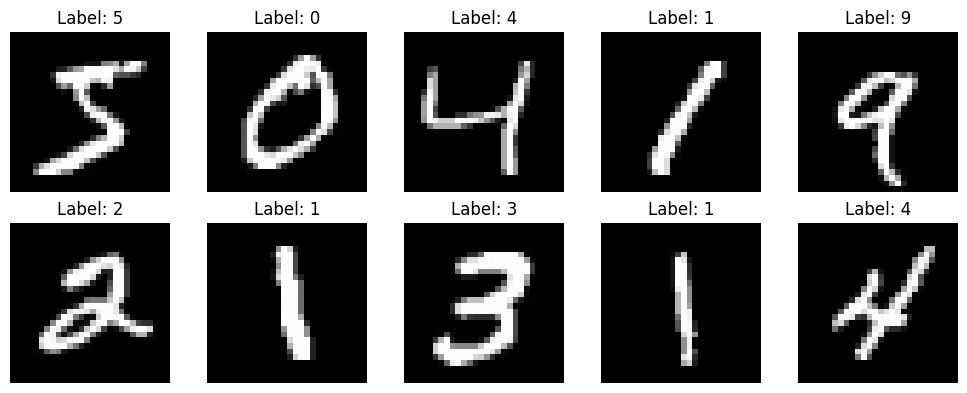

In [12]:
n = 10

# get images
imgs = [train_ds[i][0] for i in range(n)]

# get corresponding layers
labels = [train_ds[i][1] for i in range(n)]

# Plot them in a 2×5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx].squeeze().numpy()   # shape -> [28,28]
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Label: {labels[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Architecture overview (Note that all these comments were mostly for my (Elyjah Kiene's) own understanding):

# Two small conv layers (3×3 kernels, stride 1) reduce the 28×28 input down to 24×24
# and find localized features like edges and loops.
# note that convolutions are essentially filters. in our model, each kernel has 9
# LEARNABLE weights, where each output pixel is the weighted sum of the 9 input
# pixels under its 3x3 window. For example:

# Let’s say our 3×3 filter (kernel) has the following weights

# [ [ w11, w12, w13 ],
#   [ w21, w22, w23 ],
#   [ w31, w32, w33 ] ]

# And our imput image (or previous-layer feature map) is a 5×5 grid of pixel intensities:

# [ [ p11, p12, p13, p14, p15 ],
#  [ p21, p22, p23, p24, p25 ],
#  [ p31, p32, p33, p34, p35 ],
#  [ p41, p42, p43, p44, p45 ],
#  [ p51, p52, p53, p54, p55 ] ]

# To get one output pixel at position (row=2, col=2) in the next feature map, we “center” our 3×3 filter on the 5×5 input’s 3×3 subregion:

#     [ p22, p23, p24 ]
#     [ p32, p33, p34 ]
#     [ p42, p43, p44 ]

# Multiply elementwise by the kernel weights, sum them up, and optionally add a bias term.
# That sum is the new output pixel at (2,2) in the convolved feature map.

# (p22 * w11) + (p23 * w12) + (p24 * w13) ... = p(2,2)

# Important note: a "filter" (kernel) in convolutions is the 3x3 matrix of learnable weights that 
# slide over its input to create N "feature maps", which are a WxH matrix of individual activations.
# when relu is applied, each activation in the feature map is looked at. When a feature map is "dropped", 
# it means each activation in it is zeroed out.

# Max pooling (2×2) halves spatial dimensions (24 -> 12), 
# significantly reducing the feature-map size while still preserving spatial information.

# Dropout (0.25 after conv, 0.5 after dense) helps prevent overfitting on a 
# dataset that’s relatively small (60K train images).

# 9216→128 fully connected bottleneck forces the network to compact the 
# convolutional features into a smaller representation before final classification.

# Final log_softmax is exactly what NLLLoss expects, making training stable and straightforward.

# Set hyperparameters
batch_size = 128
learning_rate = 0.001

# We do not need anymore than 10 for this model
# due to the effective archetecture
num_epochs = 10

# load data
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Define a simple convolutional neural network
# This was retrieved from https://www.geeksforgeeks.org/applying-convolutional-neural-network-on-mnist-dataset/
# with a slight tweak from AI (adding the second dropout to prevent overfitting)
# and further help converting it from Keras to PyTorch.
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride)
        # learn spatial filters to detect edges, curves, etc.

        # 32 filters, results in 32 feature maps. filters here are [3, 3]
        self.conv1 = nn.Conv2d(1, 32, 3, 1)

        # 64 filters, results in 64 feature maps. In this case, each filter is actually
        # a 3D block of weight with the shape [32, 3, 3] because it is looking at every one of the 32 previous
        # feature maps at the same time in the same relative position.
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # randomly zeroes out entire channels with probability p during training.
        # regularizes the convolutional part to reduce overfitting such that
        # the model doesn't rely on a single feature map
        self.dropout1 = nn.Dropout2d(0.25)

        # Make first fully connected layer that introduces bottleneck (9212 -> 128)
        # This layer learns to combine the 9 216 pooled‐feature activations into 128 higher‐order “concepts.”
        # For example, one hidden unit might fire strongly if it sees a loop
        # at the top and two vertical strokes beneath (a “9” pattern), 
        # while another might fire if it sees a slanted line from top‐left
        # to bottom‐right plus a little horizontal bridge (a “7” feature pattern).
        self.fc1 = nn.Linear(9216, 128)
        
        self.dropout2 = nn.Dropout(0.5)

        # Make second fully connected layer that learns to map the 128 "concepts" into 10 raw scores.
        self.fc2 = nn.Linear(128, 10)

    # Define forward pass
    def forward(self, x):
        # injects non-linearlity on our first convolution
        # creates a shape of [32,26,26]
        # note that in normal NNs, the input here would be a 1d 1x784 tensor.
        # however, convolutions exploit spacial patterns like loops and edges
        # and therefore the actual structure of the image is kept in tact here.
        # if we used a normal flattened NN, then points would no longer
        # have spacial information, or in other words, the ability to say 
        # "this pixel is to the left of this pixel".
        
        # Each filter “slides” over the 28×28 input grid,
        # taking a weighted sum of each 3×3 subpatch and produces a 26×26 feature map. 
        # So we end up with 32 feature maps, each 26×26. Tensor shape becomes [batch, 32, 26, 26].
        # intuitively each of those 32 filters has (initially random) 
        # weights that will eventually specialize to “look for” a 
        # particular 3×3 pattern (say, a vertical edge, or a little curve). 
        # Wherever that pattern appears in the 28×28 image, that filter’s output map will show a strong activation.
        x = self.conv1(x)

        # apply ReLU to each of the 32 feature maps. Negative sums → zero; positive sums → remain.
        x = nn.functional.relu(x)

        # second convolution
        # creates a shape of [64,24,24]
        # Each 3×3 region spans all 32 input channels, 
        # computing 32×9 multiplications and adding them up to one output pixel. 
        # Doing that over all 24×24 possible positions yields a 24×24 map. 
        # And since there are 64 such filters, we end up with [batch, 64, 24, 24].
        # now each of those 64 filters “has a view at a 3×3 patch across all 32 feature maps.”
        # meaning that each filter is technically of a shape of [32, 3, 3].
        # For example, if one of layer-1’s maps highlighted “horizontal edges” 
        # and another highlighted “vertical edges,” a layer-2 filter might 
        # learn to fire only when it sees both edge types in one small
        # neighborhood meaning its looking at a corner.
        x = self.conv2(x)            
        x = nn.functional.relu(x)

        # At this point, we can imagine that we have a team of 64
        # people who are all really good at finding certain small aspects
        # about an image.

        # Slides a 2×2 window over each of the 64 24×24 feature-maps. 
        # For each non-overlapping 2×2 block, it picks the maximum value.
        # this downscales ou64 feature maps to 12x12
        # [batch,64,12,12]
        # since handwriting is sloppy sometimes, this is what gives the 
        # net some tolerance to slight shifts 
        # (like if some corner is one pixel to the right, max pooling still catches it).
        x = nn.functional.max_pool2d(x, 2)

        # dropout a random feature map to prevent too much overfitting on certain feature maps
        # A single “channel” after pooling is a 12×12 map that was highlighting, say, horizontal-edge positions. 
        # If we drop that whole channel, the network can’t rely on “those horizontal edges” 
        # for this particular input; it must learn to combine other channels 
        # (maybe diagonal edges, vertical edges) to succeed. Over many training passes, 
        # the network becomes robust enough that even if any quarter of 
        # its channels vanish, it still correctly classifies digits.
        x = self.dropout1(x)

        # transition from convolutional feature extraction to classification
        # collapses dims 1, 2, 3 (64 × 12 × 12) into one long vector of length 9216.
        # [batch,64*12*12=9216]
        x = torch.flatten(x, 1)

        # first dense layer. Introduces bottleneck from 9216 -> 128
        x = self.fc1(x)
        x = nn.functional.relu(x)

        # each of those 128 units can be thought of as 
        # “I see a little loop on top and a diagonal stroke on bottom,” or 
        # “I see two vertical lines and a horizontal bar.” ReLU zeros out anything negative.

        # dropout a random feature map to prevent much overfitting on certain feature maps
        # if we have 128 “digit-concept detectors” (loops, corners, slants, etc.), 
        # then dropping half means the final classification layers must learn to not 
        # depend on any one concept too heavily. They have to spread out the 
        # “knowledge” so that even if half of the concepts vanish,
        # the net can still decide “this is most likely a 7.”
        x = self.dropout2(x)

        # second output dense layer. goes from 128 -> 10 (our desired output classifications)
        x = self.fc2(x)
        
        # produces a probability distribution over the 10 output classes.
        # we don't use normal softmax because our loss function (NLLLoss, Negative Log Likelihood Loss)
        # expects log-probabilities as input.
        # Combining log_softmax + NLLLoss is apparently more numerically 
        # stable than softmax + CrossEntropyLoss when done separately

        # each number 0-9 in this shape corresponds to a log-probability of 
        # "how likely is this digit a 0? 3? 8?"

        # Multiplying many small probabilities (which happens in some models) 
        # can underflow to zero. By summing logs instead, we stay in a safer numerical range.
        # softmax here makes each entry sum to 1, so they form a valid probability 
        # distribution
        return nn.functional.log_softmax(x, dim=1)

# Send our model to the GPU
model = SimpleCNN().to(device)

# Optimizer and loss function. We could use SDG here as well, but Adam
# seems to work a little better in most cases.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# We use NLLLoss here in conjunction with log_softmax because
# internally, all it does is -log(z) (where z is log(p) in this case due to log_softmax). if we were to use the other common
# loss function here, CrossEntropyLoss, internally it does 
# softmax(z) (turns logits into probabilities) -> log(...) -> nll_loss.
# the first softmax call expects a raw logit, not a log probability,
# therefore giving us the incorrect loss.
criterion = nn.NLLLoss()

In [14]:
%%timeit -n1 -r1
# for ease, this times this code cell.
# This should output something like:
# 58.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
# where the 58.4 s is how long this code took to run

# Training loop
for epoch in range(1, num_epochs + 1):
    # enter training mode. This tells pytorch that parameters are going to be changed.
    # for example, our dropout layers will randomly zero out activations during training, 
    # but this should be turned off that randomness during evaluation (happens when we enter evaluation mode).
    # We want dropout active when we're updating weights, 
    # because that regularizes the model. But we don’t want dropout 
    # “dropping” units while we're simply measuring how well the model performs at the end of an epoch.
    model.train()
    
    total_loss = 0
    for data, target in train_loader:
        # move 128 image batch to the GPU
        data, target = data.to(device), target.to(device)

        # Every time we call .backward() (later in this loop), 
        # PyTorch accumulates gradients into each parameter’s .grad field.
        # We call zero_grad() to reset all gradients to zero before computing 
        # new ones for this batch. Otherwise, gradients from the previous batch would mix in.
        optimizer.zero_grad()

        # Runs the forward pass on the 128 batch
        output = model(data)

        # criterion was defined as nn.NLLLoss(). That takes the model’s
        # log-probabilities and the true labels (integers 0–9) to 
        # produce a single scalar: the AVERAGE “negative log likelihood” over this batch of 128.
        loss = criterion(output, target)

        # The magical backpropagation step that PyTorch handles for us.
        # After this, each param.grad field is populated with the 
        # gradient of the loss with respect to that parameter, evaluated on this minibatch.
        # this essentially is what points us to the minima of our error surface. 
        # This does not update our weights and biases, it only tells us which direction to 
        # step and with what magnitude to reduce loss.
        loss.backward()

        # This is our gradient descent step, Adam (similar to SGD, or stochastic gradient descent).
        # This is where the weights and baises are nudged such that the next time the
        # same inputs appear, the predicted probabilities should (hopefully) be closer to the correct labels.
        # this uses the gradients calculated from backpropagation and actually applies them and updates
        # our weights and biases.
        optimizer.step()

        # Add to total loss
        total_loss += loss.item()

    # Get our average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}/{num_epochs}, Training loss: {avg_loss:.4f}")
    
    # Validation step for this epoch to track progress
    # Switch to evaluation mode.
    # In our case, the dropout layers will now become inactive.
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Send test batch to GPU
            data, target = data.to(device), target.to(device)

            # argmax(dim=1) picks, for each image in the batch, 
            # “which of the 10 classes has the largest log-probability?”. 
            # A 1D tensor of length batch_size, e.g. [3, 7, 1, 1, 9, …], one predicted digit per image.
            pred = model(data).argmax(dim=1)

            # Compare each predicted digit to the true label
            correct += (pred == target).sum().item()

    # Get our accuracy
    accuracy = correct / len(test_ds)
    print(f"Test set accuracy: {accuracy*100:.2f}%\n")

Epoch 1/10, Training loss: 0.2250
Test set accuracy: 98.43%

Epoch 2/10, Training loss: 0.0865
Test set accuracy: 98.79%

Epoch 3/10, Training loss: 0.0674
Test set accuracy: 98.85%

Epoch 4/10, Training loss: 0.0559
Test set accuracy: 98.95%

Epoch 5/10, Training loss: 0.0471
Test set accuracy: 99.14%

Epoch 6/10, Training loss: 0.0426
Test set accuracy: 99.20%

Epoch 7/10, Training loss: 0.0364
Test set accuracy: 99.13%

Epoch 8/10, Training loss: 0.0321
Test set accuracy: 99.06%

Epoch 9/10, Training loss: 0.0305
Test set accuracy: 99.11%

Epoch 10/10, Training loss: 0.0291
Test set accuracy: 99.07%

43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Why, in summary, this architecture works with such little epochs

Locality: Digit classification depends on tiny local strokes (edges, curves).

- 3×3 convolutions are perfect for capturing these, setting the stage for accurate classification immediately.

Hierarchical Composition: Next layer builds bigger patterns out of smaller ones.

- Two conv layers can already see “loops”, “crossings”, “endpoints” etc.

Spatial Invariance: Max‐pool makes the network robust to small shifts or jitters.

- Handwriting is messy but pooling gives a little slack.

Regularization: Dropout (25 % on conv feature maps, 50 % on dense layer) forces the model to generalize.

- Prevents overfitting on a relatively small dataset.

In other words, the network looks for little strokes and puts them together into more recognizable shapes. Then pools to ignore tiny shifts and compacts everything into a handful of important ‘digit‐concept’ signals. Finally decides which digit fits best. Its size and dropout mean it’s big enough to learn all ten digits but small enough to not memorize every quirk.

The effectiveness here lies in the convoulations we used, in our case a convolutional kernel (e.g. 3×3) only sees a 3×3 patch of the image at a time. This is fine, because edges, small corners, and curves are inherently localized features—if we stare at just a 3×3 or 5×5 block of pixels, we can already tell if there’s a dark‐to‐light transition or a corner/curve forming.

By focusing on small areas, each convolutional filter can become a “specialist” at recognizing one simple pattern (vertical edge, horizontal edge, diagonal line, small curve, etc.) wherever it appears in the image, making it effective for finding handwriting patterns.

---

Calculating the number of parameters in this model (for fun)

Conv1 = nn.Conv2d(1, 32, kernel_size=3)

- Each of the 32 filters is shape [in_channels=1, height=3, width=3], or 9 weights per filter.

- Total weights in conv1 = 32 × 1 × 3 × 3 = 288

- Plus 32 bias terms (one per filter) = 32.

So conv1 alone contributes 288 + 32 = 320 scalar parameters.

- Conv2 = nn.Conv2d(32, 64, kernel_size=3)

- Now each of the 64 filters is shape [in_channels=32, height=3, width=3], or 288 weights per filter.

- Total conv2 weights = 64× 32 × 3 × 3 = 64 × 288 = 18,432

- Plus 64 biases = 64.

- So conv2 contributes 18,432 + 64 = 18,4966 parameters.

After those conv blocks, we flattened into 9,216 features and fed into a 128-unit linear layer:

- fc1 = nn.Linear(9216, 128)

- That has 9216 × 128 = 1,179,648 weights, plus 128 biases = 1,179,776 parameters.

- fc2 = nn.Linear(128, 10)

- That has 128 × 10 = 1,280 weights, plus 10 biases = 1,290 parameters.

**320  +  18,496  +  1,179,776  +  1,290  =  1,199,882 total parameters.**

## We now show some different architectures to run MNIST, and how long it takes, showing the need for GPUs when training models with big data, for example images, and for many epochs. For example, MNIST images are greyscale and 28 x 28 pixels, so any larger images will require more compute power!

## Example 1: Running MNIST on Kaggle

By: Jackson Harrower and Isabella Cooper

### Jackson's Run
My code loaded the MNIST dataset on kaggle notebook editor used strictly CPU through tensorflow and for 50 epochs took 310.79 seconds or 5 minutes 10 seconds, the final epoch had accuracy: 0.9989 and loss: 0.0033

### Performance Notes
- Trained the model for 50 epochs
- First MNIST dataset load (from file) took **~ 349 seconds** using CPU
- Second dataset load took **~351.55 seconds**
- Model training was completed without GPU acceleration


## Example 2: Bonus: Running under Apple Metal

By: Brent Monning

Of course, CUDA is not the only parallel computing technology that can be used to train a model off MNIST, given that it is designed to only work with Nvidia cards. One can use ROCM, OpenCL, DirectML, Metal, and whatnot, but this short bonus section will be dedicated to how model training performs under Metal. The model training will be done in Tensorflow, which will determine optimal hardware as soon as the module is loaded, and testing was done on an Apple M1 with 7 GPU cores.

One thing that is noticable immediately upon training without an accuracy cap is that, despite the same snippet, the Metal driver will just consistently generate more and more error. Around (put elapsed here) went by.

![Loss and Accuracy Graphs of Uncapped M1](img/metal-uncapped.png)

On the other hand, the CUDA notebook with the same snippet does not have this issue. This took (put elapsed here).

![Loss and Accuracy Graphs of Uncapped CUDA Instance](img/cuda-uncapped.png)

When given a cap of 98.5% accuracy, where training will immediately conclude if this accuracy was exceeeded, the M1 takes (put elapsed here), whilst the CUDA instance on another machine takes (put elapsed here). The accuracy is about the same as shown below, albeit there are far less training epochs that were performed as opposed to the 50 training epochs prior. [There is a GitHub issue open on the Tensorflow Keras source repository, and whilst it is closed and said to be resolved in newer versions, some say it is still a problem.](https://github.com/keras-team/tf-keras/issues/140)

Below is the M1:

![Loss and Accuracy Graphs of Capped M1](img/metal-capped.png)

And below is the CUDA instance:

![Loss and Accuracy Graphs of Capped CUDA Instance](img/cuda-capped.png)

For the next few, we'll only be focusing on the Metal results using the M1 chip. Two confusion matrixes, one using a linear colorbar for values, and another using a logarithmic colorbar, are provided below:

![Confusion Matrix using a Linear Colorbar](img/metal-confusion-linear.png)

![Confusion Matrix using a Logarithmic Colorbar](img/metal-confusion-logarithmic.png)

And here is a scatterplot visualization of each numeral using Scikit Learn's TSNE module.

![TSNE Cluster Scatterplot visualization of our Metal-powered model](img/metal-tsne.png)

# Example 3: Keras Neural Network 
By: Jeovanni Mendez, Laura Lovrein, and Ryan Dean
<p style="font-size:25px;">When we used the  MNIST dataset to train a neural network model using Keras via Tensorflow, training with 50 epochs using CPU only took a total of 386.25 seconds with an accuracy of 0.979.  </p>

# Example 4: MNIST with google colab using tensorflow
by: Bailey Baker, Julian Loutzenhiser, and Katherine Nunn

<p style="font-size:25px;">Using tensorflow in a google colab notebook, the model took an average of 49.3 seconds to train with 10 epochs and achieved a test accuracy of 97.97% with 0.2971 loss. <p>

# Example 5: MNIST with Keras
by: Nate Cook

<p style="font-size:25px;"> I used Keras with 50 epochs on the MNIST dataset, training took 996.63 seconds and I ended with a accuracy of .993.